<a href="https://colab.research.google.com/github/nishaz/DSA-Algorithm-Analysis/blob/main/Experiment_DijkstraAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time, math, heapq, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import heapq

from collections import defaultdict

# Algorithm 1: Adjacency Matrix + Array Priority Queue
Goal: Implement Dijkstra’s algorithm using an adjacency matrix and a simple array-based priority queue.

* Theoretical Complexity: O(V^2)
* Suitable for small or dense graphs

In [ ]:
def dijkstra_matrix_array(graph, source):
    V = len(graph)
    INF = float('inf')
    dist = [INF] * V
    visited = [False] * V
    dist[source] = 0

    for _ in range(V):      # O(V) iterations
        # Find min unvisited vertex - O(V)
        u = None
        min_dist = INF
        for i in range(V):  # O(V) per iteration
            if not visited[i] and dist[i] < min_dist:
                min_dist = dist[i]
                u = i

        if u is None or min_dist == INF:
            break

        visited[u] = True

        # Update neighbors - O(V)
        for v in range(V):   # O(V) per iteration
            if not visited[v] and graph[u][v] != INF:
                new_dist = dist[u] + graph[u][v]
                if new_dist < dist[v]:
                    dist[v] = new_dist  # O(1) update

    return dist

# Algorithm 2: Adjacency List + Min-Heap Priority Queue

Goal: Implement Dijkstra’s algorithm using adjacency lists and a minimizing heap for PQ

* Theoretical Complexity: O((V + E) log V)
* Suitable for large or sparse graphs

In [ ]:
def dijkstra_list_heap(graph, source):
    V = len(graph)
    dist = [math.inf] * V     # O(V)
    dist[source] = 0
    visited = [False] * V     # O(V)

    pq = [(0, source)]        # O(1)
    heapq.heapify(pq)         # O(1) - already heapified

    while pq:    # O(V) iterations
        d, u = heapq.heappop(pq)      # O(log E) per iteration
        if visited[u]:
            continue
        visited[u] = True

        for v, w in graph[u]:    # O(degree(u)) per iteration
            if not visited[v] and dist[v] > d + w:
                dist[v] = d + w
                heapq.heappush(pq, (dist[v], v))    # O(log E) per push

    return dist

# Graph Generators

Produces:
* Random sparse (E ≈ cV)
* Random dense (E ≈ V² / 4)


In [ ]:
def generate_random_graph(V, density, representation, directed=False):
    INF = float('inf')

    if representation == "matrix":
        graph = [[INF] * V for _ in range(V)] # fill matrix w infinite
        for i in range(V):
            graph[i][i] = 0 # set distance to self=0
    else:  # list
        graph = [[] for _ in range(V)] # empty adjacency list

    max_possible_edges = V * (V - 1) if directed else V * (V - 1) // 2
    target_edges = int(max_possible_edges * density)

    edges_added = 0

    # Use a set to track edges for faster lookup
    edge_set = set()

   while edges_added < target_edges:
        u = random.randint(0, V - 1)  # Random source
        v = random.randint(0, V - 1)  # Random target
        if u == v:
          continue           # Skip self-loops

        w = random.randint(1, 10)     # Random weight 1-10

        # Create unique edge identifier
        if directed:
            edge_id = (u, v)              # Directed: (u,v) ≠ (v,u)
        else:
            edge_id = tuple(sorted((u, v))) # Undirected: (u,v) = (v,u)

        if edge_id not in edge_set:  # O(1) lookup!
            edge_set.add(edge_id)

            if representation == "matrix":
                graph[u][v] = w              # Set weight at position (u,v)
                if not directed:
                    graph[v][u] = w          # Add reverse edge for undirected
            else:  # list
                graph[u].append((v, w))      # Add to u's neighbor list
                if not directed:
                    graph[v].append((u, w))  # Add reverse edge for undirected

            edges_added += 1

    return graph

# Run Experiments

1. Implement experiment function with averaging of results through trials
2. Call experiment function for Random Sparse and Random Densities graphs for each implementation
3. Call experiment function in Loop for results for varying density (E)


In [ ]:
# Experiment Function
def run_experiment(algo_func, V, density, representation, trials=3):

    G = generate_random_graph(V, density=density, representation=representation)

    total_time = 0
    for _ in range(trials):
        start = time.perf_counter()
        result = algo_func(G, source=0)  # Run Dijkstra starting from vertex 0
        end = time.perf_counter()
        total_time += (end - start)

    avg_time = total_time / trials
    estimated_E = int(density * V * (V - 1))

    return {
        "V": V,
        "E": estimated_E,
        "density": density,
        "representation": representation,
        "time_sec": avg_time
    }

In [ ]:
# --- Vertex Scaling Experiment ---
sizes =  [100, 200, 400, 600, 800, 1000, 1200] # Test different graph sizes V
densities = [0.01, 0.5]  # sparse and dense
results_v = []

for V in sizes:
    for d in densities:
        results_v.append(run_experiment(dijkstra_matrix_array, V, d, "matrix"))
        results_v.append(run_experiment(dijkstra_list_heap, V, d, "list"))

# --- Varying density experiment (E sweep) ---
densities = [0.01, 0.05, 0.1, 0.25, 0.5, 1.0]
results_e = []

for d in densities:
    results_e.append(run_experiment(dijkstra_matrix_array, V=1000, density=d, representation="matrix"))
    results_e.append(run_experiment(dijkstra_list_heap, V=1000, density=d, representation="list"))


# Plot Experiment Results

Comparing 2 Dijkstra Implementations in respect to:
* |V| no. of vertices (graph size)
* no. of edges E (graph density)

For each Dijkstra Implementation:
* Time vs V (sparse graphs)
* Time vs V (dense graphs)
* Time vs E (fixed V) to show sparsity effect


# Data Points

In [ ]:
# Convert your results lists into DataFrames
df_size = pd.DataFrame(results_v)
df_density = pd.DataFrame(results_e)

display(df_size)
display(df_density)


,V,E,density,representation,time_sec
0,100,99,0.01,matrix,0.000161
1,100,99,0.01,list,0.000009
2,100,4950,0.50,matrix,0.000942
3,100,4950,0.50,list,0.000449
4,200,398,0.01,matrix,0.002736
5,200,398,0.01,list,0.000111
6,200,19900,0.50,matrix,0.004181
7,200,19900,0.50,list,0.001946
8,400,1596,0.01,matrix,0.013678
9,400,1596,0.01,list,0.000414


,V,E,density,representation,time_sec
0,1000,9990,0.01,matrix,0.099104
1,1000,9990,0.01,list,0.002628
2,1000,49950,0.05,matrix,0.092646
3,1000,49950,0.05,list,0.010759
4,1000,99900,0.10,matrix,0.100985
5,1000,99900,0.10,list,0.022635
6,1000,249750,0.25,matrix,0.108613
7,1000,249750,0.25,list,0.057448
8,1000,499500,0.50,matrix,0.202203
9,1000,499500,0.50,list,0.128836


# Theoretical vs Empirical Plots

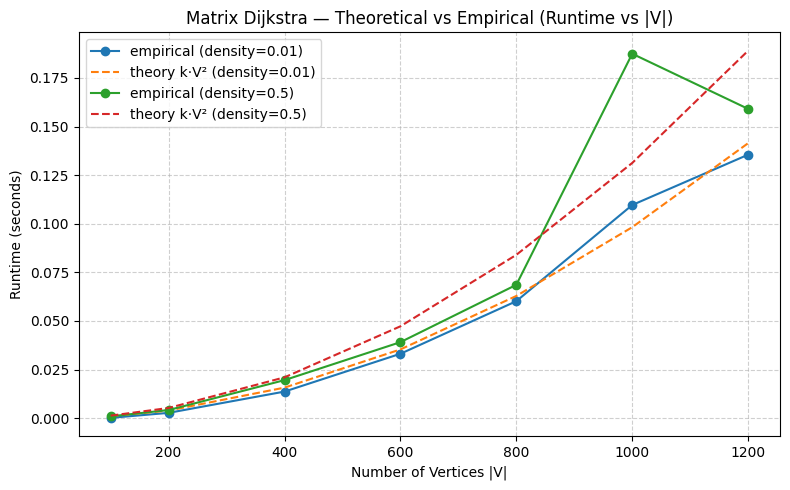

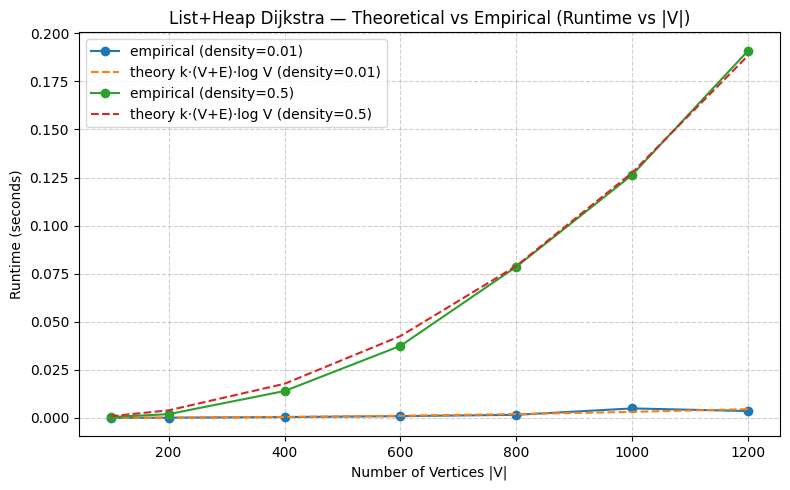

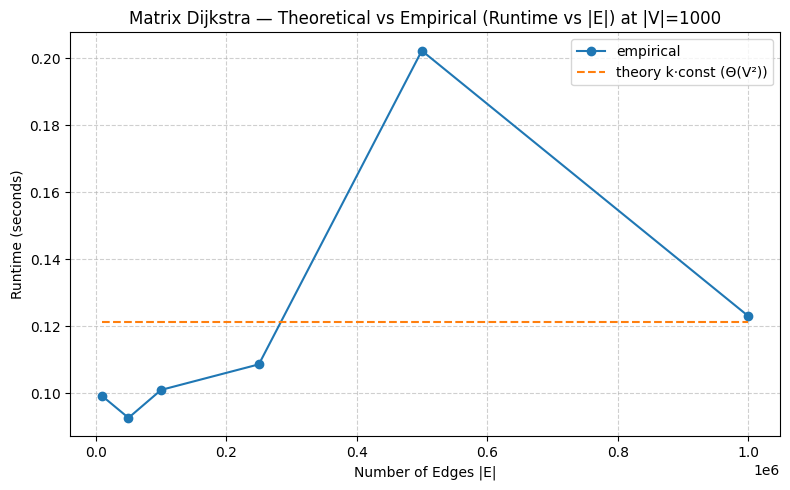

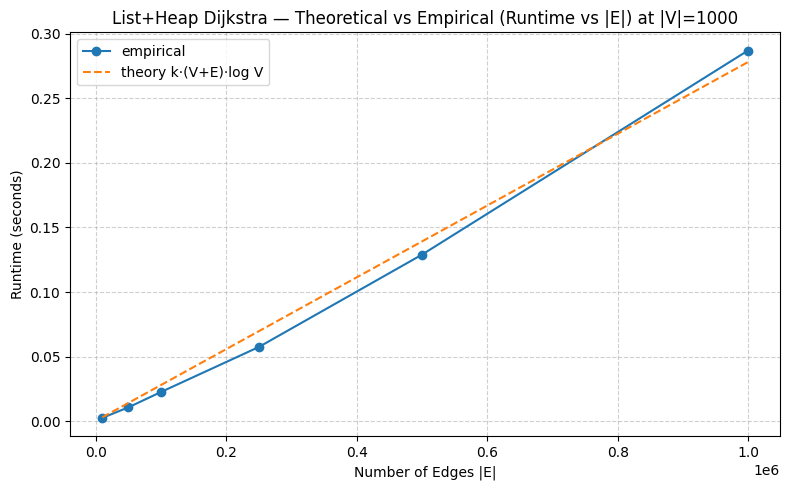

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Make sure E exists (match YOUR earlier estimate: E ≈ density * V * (V-1)) ---
def ensure_E(df):
    if 'E' not in df.columns:
        df = df.copy()
        df['E'] = (df['density'] * df['V'] * (df['V'] - 1)).astype(int)
    return df

df_size    = ensure_E(df_size)      # varying |V| (two densities)
df_density = ensure_E(df_density)   # varying density at fixed |V|

# simple scale-fit for y ≈ k * f  (no intercept)
def fit_k(f, y):
    f = np.asarray(f, float); y = np.asarray(y, float)
    num = (f * y).sum(); den = (f * f).sum()
    return 0.0 if den == 0 else num / den

# ============================================================================
# 1) MATRIX — Theoretical vs Empirical (runtime vs |V|)
# Theory: Θ(V^2)
# ============================================================================
plt.figure(figsize=(8,5))
for dens, sub in df_size[df_size['representation']=='matrix'].groupby('density'):
    sub = sub.sort_values('V')
    V = sub['V'].to_numpy()
    y = sub['time_sec'].to_numpy()
    f = V**2
    k = fit_k(f, y)
    plt.plot(V, y, marker='o', label=f'empirical (density={dens})')
    plt.plot(V, k*f, linestyle='--', label=f'theory k·V² (density={dens})')

plt.title("Matrix Dijkstra — Theoretical vs Empirical (Runtime vs |V|)")
plt.xlabel("Number of Vertices |V|")
plt.ylabel("Runtime (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================================
# 2) LIST — Theoretical vs Empirical (runtime vs |V|)
# Theory: Θ((V + E) log V)
# ============================================================================
plt.figure(figsize=(8,5))
for dens, sub in df_size[df_size['representation']=='list'].groupby('density'):
    sub = sub.sort_values('V')
    V = sub['V'].to_numpy()
    E = sub['E'].to_numpy()
    y = sub['time_sec'].to_numpy()
    f = (V + E) * np.log2(np.maximum(V, 2))
    k = fit_k(f, y)
    plt.plot(V, y, marker='o', label=f'empirical (density={dens})')
    plt.plot(V, k*f, linestyle='--', label=f'theory k·(V+E)·log V (density={dens})')

plt.title("List+Heap Dijkstra — Theoretical vs Empirical (Runtime vs |V|)")
plt.xlabel("Number of Vertices |V|")
plt.ylabel("Runtime (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================================
# 3) MATRIX — Theoretical vs Empirical (runtime vs |E|)
# For fixed |V|, Matrix is Θ(V²) → flat vs |E|
# ============================================================================
mat = df_density[df_density['representation']=='matrix'].sort_values('E')
V_fixed = int(mat['V'].iloc[0]) if len(mat) else 0
f = np.ones(len(mat))  # constant in E
k = fit_k(f, mat['time_sec'].to_numpy())

plt.figure(figsize=(8,5))
plt.plot(mat['E'], mat['time_sec'], marker='o', label='empirical')
plt.plot(mat['E'], k*f, linestyle='--', label='theory k·const (Θ(V²))')
plt.title(f"Matrix Dijkstra — Theoretical vs Empirical (Runtime vs |E|) at |V|={V_fixed}")
plt.xlabel("Number of Edges |E|")
plt.ylabel("Runtime (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================================
# 4) LIST — Theoretical vs Empirical (runtime vs |E|)
# For fixed |V|, theory: Θ((V + E) log V) = k·(E + V_fixed)·log V_fixed
# ============================================================================
lst = df_density[df_density['representation']=='list'].sort_values('E')
V_fixed = int(lst['V'].iloc[0]) if len(lst) else 0
E = lst['E'].to_numpy()
y = lst['time_sec'].to_numpy()
f = (V_fixed + E) * np.log2(max(V_fixed, 2))
k = fit_k(f, y)

plt.figure(figsize=(8,5))
plt.plot(E, y, marker='o', label='empirical')
plt.plot(E, k*f, linestyle='--', label='theory k·(V+E)·log V')
plt.title(f"List+Heap Dijkstra — Theoretical vs Empirical (Runtime vs |E|) at |V|={V_fixed}")
plt.xlabel("Number of Edges |E|")
plt.ylabel("Runtime (seconds)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Time vs |V| (for sparse & dense graphs)

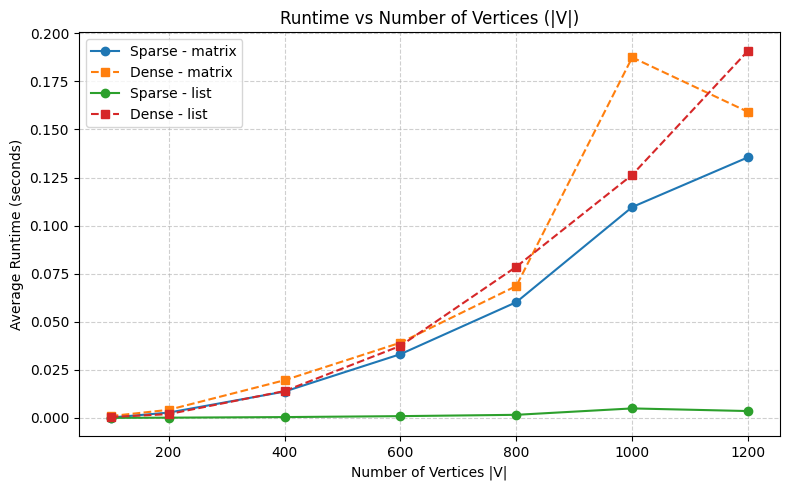

In [ ]:
plt.figure(figsize=(8,5))
for rep in df_size['representation'].unique():
    subset_sparse = df_size[(df_size['representation']==rep) & (df_size['density']<=0.01)]
    subset_dense = df_size[(df_size['representation']==rep) & (df_size['density']>=0.5)]

    plt.plot(subset_sparse['V'], subset_sparse['time_sec'], marker='o', label=f"Sparse - {rep}")
    plt.plot(subset_dense['V'], subset_dense['time_sec'], marker='s', linestyle='--', label=f"Dense - {rep}")

plt.title("Runtime vs Number of Vertices (|V|)")
plt.xlabel("Number of Vertices |V|")
plt.ylabel("Average Runtime (seconds)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Time vs |E| (V fixed = 1000)

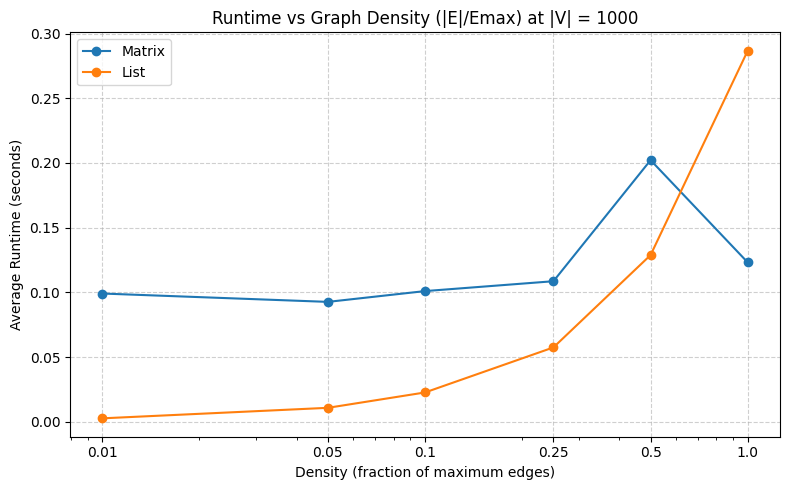

In [ ]:
plt.figure(figsize=(8,5))
for rep in df_density['representation'].unique():
    subset = df_density[df_density['representation']==rep]
    plt.plot(subset['density'], subset['time_sec'], marker='o', label=rep.capitalize())

plt.title("Runtime vs Graph Density (|E|/Emax) at |V| = 1000")
plt.xlabel("Density (fraction of maximum edges)")
plt.ylabel("Average Runtime (seconds)")
plt.xscale('log')
# Set proper x-ticks
plt.xticks([0.01, 0.05, 0.1, 0.25, 0.5, 1.0], ['0.01', '0.05', '0.1', '0.25', '0.5', '1.0'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Combined Comparison

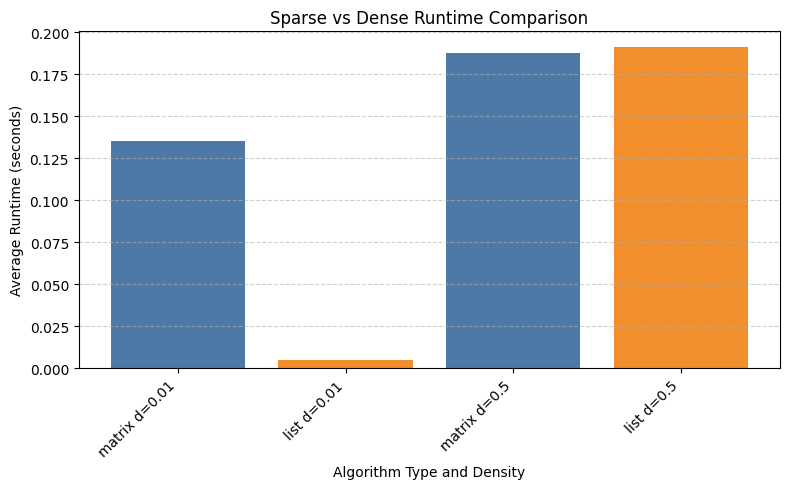

In [ ]:
plt.figure(figsize=(8,5))
labels = [f"{r['representation']} d={r['density']}" for _,r in df_size.iterrows()]
plt.bar(labels, df_size['time_sec'],
        color=['#4e79a7' if r=="matrix" else '#f28e2b'
               for r in df_size['representation']])
plt.title("Sparse vs Dense Runtime Comparison")
plt.xlabel("Algorithm Type and Density")
plt.ylabel("Average Runtime (seconds)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#  Analysis & Discussion



###  Theoretical Comparison
- **Adjacency Matrix + Array**: O(V²)
- **Adjacency List + Heap**: O((V + E) log V)

###  Empirical Observations
- For **small or dense graphs**, the Matrix+Array implementation performs similarly or even better due to its constant-time edge access and low overhead.
- For **large or sparse graphs**, List+Heap clearly dominates as the overhead of traversing unnecessary edges is avoided.

###   Explanation
- **Sparse graphs** have very few edges, and the adjacency list structure avoids iterating over non-existent (zero-weight) connections. This significantly improves efficiency.
- The **heap-based priority queue** (via `heapq`) ensures the next vertex is selected in log time, reducing the bottleneck of linear scans in large graphs.


# Conclusion



The results clearly demonstrate that the choice of graph representation and priority structure has a substantial impact on Dijkstra's algorithm performance.

- For **dense or small graphs**, Matrix + Array can be acceptable due to simplicity and constant-time edge lookups.
- For **sparse or large graphs**, List + Heap is far superior, offering both theoretical and practical speedups.

In real-world scenarios—where most graphs are sparse—the List + Heap approach is not only more scalable but also more aligned with the theoretical O((V + E) log V) complexity.
